# HDA - Project 3: TASK A
## Classification of Modes of Locomotion
This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

In [1]:
import utils
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# parameters definition

subject = 1
folder = "./data/reduced/"
label_col = 0     # default for task A
window_size = 50
stride = 50

# Section 1 - Loading and Preprocessing

### Dataset Loading 

In [3]:
# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features_interp'],\
                          data2['features_interp'],\
                          data3['features_interp'],\
                          data6['features_interp']), axis=0)

Y_train = np.concatenate((data1['labels_cut'][:,label_col],\
                          data2['labels_cut'][:,label_col],\
                          data3['labels_cut'][:,label_col],\
                          data6['labels_cut'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features_interp'],\
                         data5['features_interp']), axis=0)

Y_test = np.concatenate((data4['labels_cut'][:,label_col],\
                         data5['labels_cut'][:,label_col]))

features = X_test.shape[1]
print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)


Session shapes:
ADL1:   (45810, 58)
ADL2:   (28996, 58)
ADL3:   (30167, 58)
ADL4:   (30228, 58)
ADL5:   (27308, 58)
Drill:  (52152, 58)

Training samples:  157125 
Test samples:       57536 
Features:             58


### Dataset preparation in order to feed it to the network

In [4]:
# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])

print("Training set:")
X_train_s, Y_train_s = utils.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False)
print("\nTest set:")
X_test_s, Y_test_s = utils.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False)
# add bars plot


Classes in training set:  5 
Classes in test set:      5
Training set:
<class 'numpy.ndarray'> (3141, 50, 58) <class 'numpy.ndarray'> (3141, 5)

Features have shape:  (3141, 50, 58) 
Labels have shape:    (3141, 5) 
Fraction of labels:   [0.10983763 0.4237504  0.27029608 0.17191977 0.02419612]

Test set:
<class 'numpy.ndarray'> (1149, 50, 58) <class 'numpy.ndarray'> (1149, 5)

Features have shape:  (1149, 50, 58) 
Labels have shape:    (1149, 5) 
Fraction of labels:   [0.17928634 0.34290688 0.20104439 0.23846823 0.03829417]


# Section 2 - Classification with Conv1D

### Creation of one-dimensional convolutional neural network

In [5]:
classes = np.max((Y_train_s.shape[1], Y_test_s.shape[1]))

In [6]:
model_unidim = utils.Model1D((window_size, features), classes)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 18)            5238      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 18)            72        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 18)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 18)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 36)            4572      
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 36)            144       
___________________________________________________________

In [7]:
opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [8]:
model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test_s, Y_test_s))

Train on 3141 samples, validate on 1149 samples
Epoch 1/10
3141/3141 [==============================] - 4s 1ms/step - loss: 2.0585 - acc: 0.6705 - val_loss: 1.1818 - val_acc: 0.8451
Epoch 2/10
3141/3141 [==============================] - 2s 698us/step - loss: 0.9685 - acc: 0.7950 - val_loss: 0.6171 - val_acc: 0.8895
Epoch 3/10
3141/3141 [==============================] - 2s 690us/step - loss: 0.6178 - acc: 0.8182 - val_loss: 0.5245 - val_acc: 0.8773
Epoch 4/10
3141/3141 [==============================] - 2s 711us/step - loss: 0.5006 - acc: 0.8329 - val_loss: 0.4983 - val_acc: 0.8729
Epoch 5/10
3141/3141 [==============================] - 2s 699us/step - loss: 0.4594 - acc: 0.8459 - val_loss: 0.4860 - val_acc: 0.8851
Epoch 6/10
3141/3141 [==============================] - 2s 706us/step - loss: 0.4502 - acc: 0.8488 - val_loss: 0.5502 - val_acc: 0.8547
Epoch 7/10
3141/3141 [==============================] - 2s 734us/step - loss: 0.4181 - acc: 0.8586 - val_loss: 0.5566 - val_acc: 0.8642
Ep

### Classification and evaluation of performances

In [9]:
# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

In [10]:
# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

F1-measure:  0.8468201177977069
AUC w.r. to each class:  {0: 0.9207600201793491, 1: 0.9769926379130668, 2: 0.9412424902620982, 3: 0.9984150156412931, 4: 0.8635129576306046}


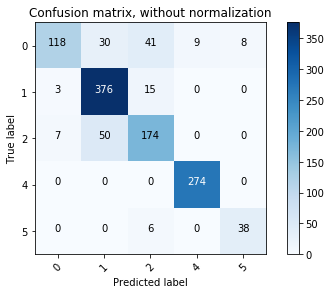

In [11]:
# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')

# Section 3 - Classification with Conv2D

In [12]:
model_new2D = utils.Model2D((1,window_size,features), classes)
opt4 = Adam(lr=0.01)
model_new2D.compile(optimizer = opt4, loss = "categorical_crossentropy", metrics = ["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 17, 18)         26118     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 17, 18)         72        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1, 17, 18)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 9, 18)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 3, 36)          16236     
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 3, 36)          144       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1, 3, 36)          0         
__________

In [13]:
# need to reshape in order to fit to the new 2D model
X_train = X_train_s.reshape(X_train_s.shape[0], 1, window_size, features)
X_test = X_test_s.reshape(X_test_s.shape[0], 1, window_size, features)

model_new2D.fit(x = X_train, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test, Y_test_s))

Train on 3141 samples, validate on 1149 samples
Epoch 1/10
3141/3141 [==============================] - 4s 1ms/step - loss: 1.1706 - acc: 0.7275 - val_loss: 0.8622 - val_acc: 0.7737
Epoch 2/10
3141/3141 [==============================] - 2s 793us/step - loss: 0.5955 - acc: 0.8144 - val_loss: 0.6153 - val_acc: 0.8042
Epoch 3/10
3141/3141 [==============================] - 3s 889us/step - loss: 0.4700 - acc: 0.8376 - val_loss: 0.5804 - val_acc: 0.8242
Epoch 4/10
3141/3141 [==============================] - 3s 998us/step - loss: 0.4121 - acc: 0.8571 - val_loss: 0.4802 - val_acc: 0.8721
Epoch 5/10
3141/3141 [==============================] - 3s 869us/step - loss: 0.3850 - acc: 0.8653 - val_loss: 0.5717 - val_acc: 0.8451
Epoch 6/10
3141/3141 [==============================] - 3s 860us/step - loss: 0.3506 - acc: 0.8876 - val_loss: 0.5171 - val_acc: 0.8590
Epoch 7/10
3141/3141 [==============================] - 2s 714us/step - loss: 0.3486 - acc: 0.8812 - val_loss: 0.5728 - val_acc: 0.8512
Ep

### Classification and evaluation of performances

F1-measure:  0.8381181064649618
AUC w.r. to each class:  {0: 0.9258203008370312, 1: 0.970834033684069, 2: 0.9114770487319507, 3: 0.9987320125130343, 4: 0.8629576306046893}


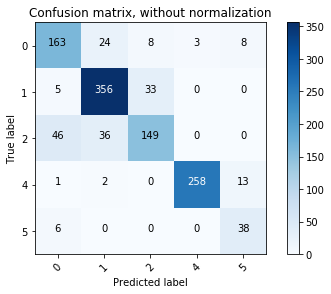

In [14]:
# predict labels
Y_pred_s = model_new2D.predict(X_test)

# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')

# Tries with different models

In [15]:
model_3 = utils.MixedModel((1,window_size,features), classes)
opt4 = Adam(lr=0.01)
model_3.compile(optimizer = opt4, loss = "categorical_crossentropy", metrics = ["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 50, 20)         11620     
_________________________________________________________________
batch_normalization_7 (Batch (None, 1, 50, 20)         80        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 17, 40)         24040     
_________________________________________________________________
batch_normalization_8 (Batch (None, 1, 17, 40)         160       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1, 17, 40)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 9, 40)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 360)               0         
__________

In [16]:
# need to reshape in order to fit to the new 2D model
X_train = X_train_s.reshape(X_train_s.shape[0], 1, window_size, features)
X_test = X_test_s.reshape(X_test_s.shape[0], 1, window_size, features)

model_3.fit(x = X_train, y = Y_train_s, epochs = 30, batch_size = 128, validation_data=(X_test, Y_test_s))

Train on 3141 samples, validate on 1149 samples
Epoch 1/30
3141/3141 [==============================] - 6s 2ms/step - loss: 1.8518 - acc: 0.6546 - val_loss: 1.1203 - val_acc: 0.8103
Epoch 2/30
3141/3141 [==============================] - 4s 1ms/step - loss: 0.8676 - acc: 0.7861 - val_loss: 0.6889 - val_acc: 0.8625
Epoch 3/30
3141/3141 [==============================] - 4s 1ms/step - loss: 0.6187 - acc: 0.8211 - val_loss: 0.5952 - val_acc: 0.8607
Epoch 4/30
3141/3141 [==============================] - 4s 1ms/step - loss: 0.5557 - acc: 0.8309 - val_loss: 0.5952 - val_acc: 0.8590
Epoch 5/30
3141/3141 [==============================] - 4s 1ms/step - loss: 0.5016 - acc: 0.8446 - val_loss: 0.5799 - val_acc: 0.8503
Epoch 6/30
3141/3141 [==============================] - 4s 1ms/step - loss: 0.5482 - acc: 0.8262 - val_loss: 0.6191 - val_acc: 0.8581
Epoch 7/30
3141/3141 [==============================] - 4s 1ms/step - loss: 0.5611 - acc: 0.8367 - val_loss: 0.5706 - val_acc: 0.8755
Epoch 8/30
314

F1-measure:  0.830039310631993
AUC w.r. to each class:  {0: 0.8848438674340311, 1: 0.9651595118835514, 2: 0.92320497222458, 3: 0.9997664233576642, 4: 0.8631221719457014}


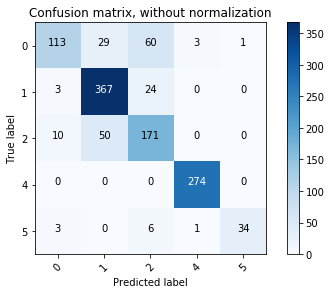

In [17]:
# predict labels
Y_pred_s = model_3.predict(X_test)

# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')